In [1]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from libpysal import graph
from scipy.spatial import distance


## Preprocess buildings

In [2]:
buildings = gpd.read_parquet("/data/uscuni-ulce/boundaries_of_change/classification/")

Remap clusters

In [3]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v3.pq"
)
final_clusters

,1,2,3,4,5,6
7,,,,,,
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,2
4,1,1,1,1,1,2
5,1,1,1,1,2,3
...,...,...,...,...,...,...
104,2,4,8,16,31,59
105,2,4,8,16,31,59
106,2,4,8,16,32,60


In [4]:
level_columns = []

In [5]:
for level in final_clusters.columns:
    buildings[f"level_{level}"] = buildings.final_without_noise.map(
        final_clusters[level]
    )
    level_columns.append(f"level_{level}")

buildings = buildings.rename(columns={"final_without_noise":"level_7"})
level_columns.append("level_7")

In [6]:
buildings.head()

,geometry,level_7,area,level_1,level_2,level_3,level_4,level_5,level_6
__null_dask_index__,,,,,,,,,
0,POINT (4099683.344 3108236.287),50,66.767646,1,2,4,8,16,30
1,POINT (4100189.13 3108803.392),1,427.019080,1,1,1,1,1,1
2,POINT (4100069.189 3109146.3),1,144.324859,1,1,1,1,1,1
3,POINT (4100144.944 3108299.666),1,139.581363,1,1,1,1,1,1
4,POINT (4100022.946 3108688.179),1,41.651016,1,1,1,1,1,1


In [7]:
gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg")

,name,geometry_type
0,1240_mongol_invasion,Polygon
1,900_political,Polygon
2,1000_political,Polygon
3,1300_ostsiedlung,Polygon
4,1550_religion,Polygon
5,1526_political,Polygon
6,1618_political,Polygon
7,1648_political,Polygon
8,1600_religion,Polygon
9,1812_political,Polygon


In [8]:
boundary_list = list(gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name)
boundary_list.remove("1812_political") #to be fixed
boundary_list.remove("1900_germans") #to be fixed
boundary_list.remove("1300_ostsiedlung") #to be fixed

<Axes: >

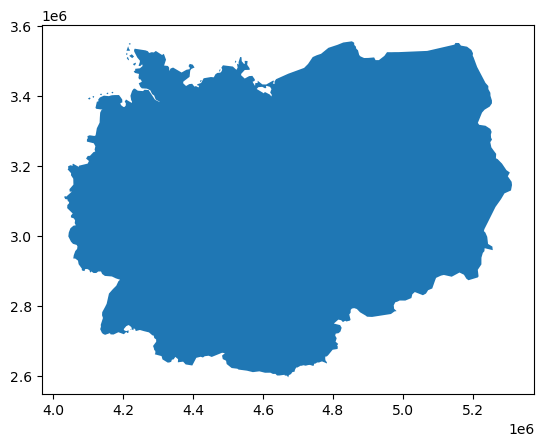

In [9]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi = aoi.dissolve()
aoi.plot()

In [10]:
def get_building_counts_per_region(buildings, boundary, level="level_4"):
    joined = gpd.sjoin(buildings, boundary, how="left", predicate="within")
    grouped = joined.groupby("NAME")[level].value_counts()
    cnt_table = pd.DataFrame(grouped.unstack().fillna(0).T)
    
    return cnt_table

In [11]:
def normalize_building_counts(count_table):
    region_building_sums = count_table.sum(axis=0)
    cnt_table_norm = count_table.div(region_building_sums, axis=1)
    return cnt_table_norm

In [12]:
def generate_bc_heatmaps_for_boundary(level_list, boundary_name):

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    
    for level, ax in zip(level_list, axs):
        bc = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_{level}.pq')
        sns.heatmap(bc, annot=True, ax=ax)
        ax.set_title(level)

    fig.suptitle(boundary_name)
    fig.tight_layout()

Outliers on rows 3,4,10 on level 4

In [13]:
def compute_bc_matrix(count_table):
    num_regions = len(count_table.columns)
    bray_curtis_matrix = np.zeros((num_regions, num_regions))

    for i in range(num_regions):
        for j in range(num_regions):
            if i != j:
                reg_i = count_table.iloc[:,i]
                reg_j = count_table.iloc[:,j]
                bray_curtis_matrix[i,j] = distance.braycurtis(reg_i, reg_j)

    bray_curtis_matrix = pd.DataFrame(bray_curtis_matrix, index=count_table.columns, columns=count_table.columns)
    return bray_curtis_matrix

In [14]:
def generate_bc_matrices(boundary_list, level_list):
    for bnd in boundary_list:
        boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
        
        for level in level_list:
            building_counts = get_building_counts_per_region(buildings, boundary, level)
            building_counts_norm = normalize_building_counts(building_counts)
            
            bray_curtis_matrix = compute_bc_matrix(building_counts_norm)
    
            bray_curtis_matrix.to_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{bnd}_{level}.pq')

In [72]:
def generate_boundary_diagram(boundary_name, ax):
    boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=boundary_name)

    bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_level_4.pq')
    
    indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
    left, right = np.unique(np.sort(indices, axis=0), axis=1)

    mask = left == right
    left = left[~mask]
    right = right[~mask]
    geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
    left = boundary.NAME.iloc[left]
    right = boundary.NAME.iloc[right]
    border_widths = []
    for l, r in zip(left, right):
        border_widths.append(bray_curtis_matrix.loc[l, r])
        
    #alphas = [(4*(np.exp(2*a) - 1)) for a in border_widths]
    #alphas = [(a - min(alphas)) / (max(alphas) - min(alphas)) for a in alphas]
    border_widths = [(0.1 + 4*(np.exp(2*w) - 1)) for w in border_widths]
    norm=plt.Normalize(min(border_widths),max(border_widths))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","black"])
    for geom, width in zip (geoms, border_widths):
        gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(width)))
        # print(geom)
    ax.set_title(f"{boundary_name}")

In [64]:
import matplotlib.colors

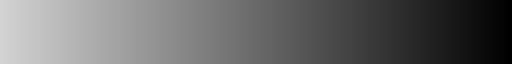

In [48]:
boundary_name = "1960_political"
boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=boundary_name)

bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_level_4.pq')
    
indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
left, right = np.unique(np.sort(indices, axis=0), axis=1)

mask = left == right
left = left[~mask]
right = right[~mask]
geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
left = boundary.NAME.iloc[left]
right = boundary.NAME.iloc[right]

border_widths = []
for l, r in zip(left, right):
    border_widths.append(bray_curtis_matrix.loc[l, r])
        
    #alphas = [(4*(np.exp(2*a) - 1)) for a in border_widths]
    #alphas = [(a - min(alphas)) / (max(alphas) - min(alphas)) for a in alphas]
border_widths = [(0.1 + 4*(np.exp(2*w) - 1)) for w in border_widths]

norm=plt.Normalize(min(border_widths),max(border_widths))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","black"])
cmap

In [70]:
norm(max(border_widths))

np.float64(1.0)

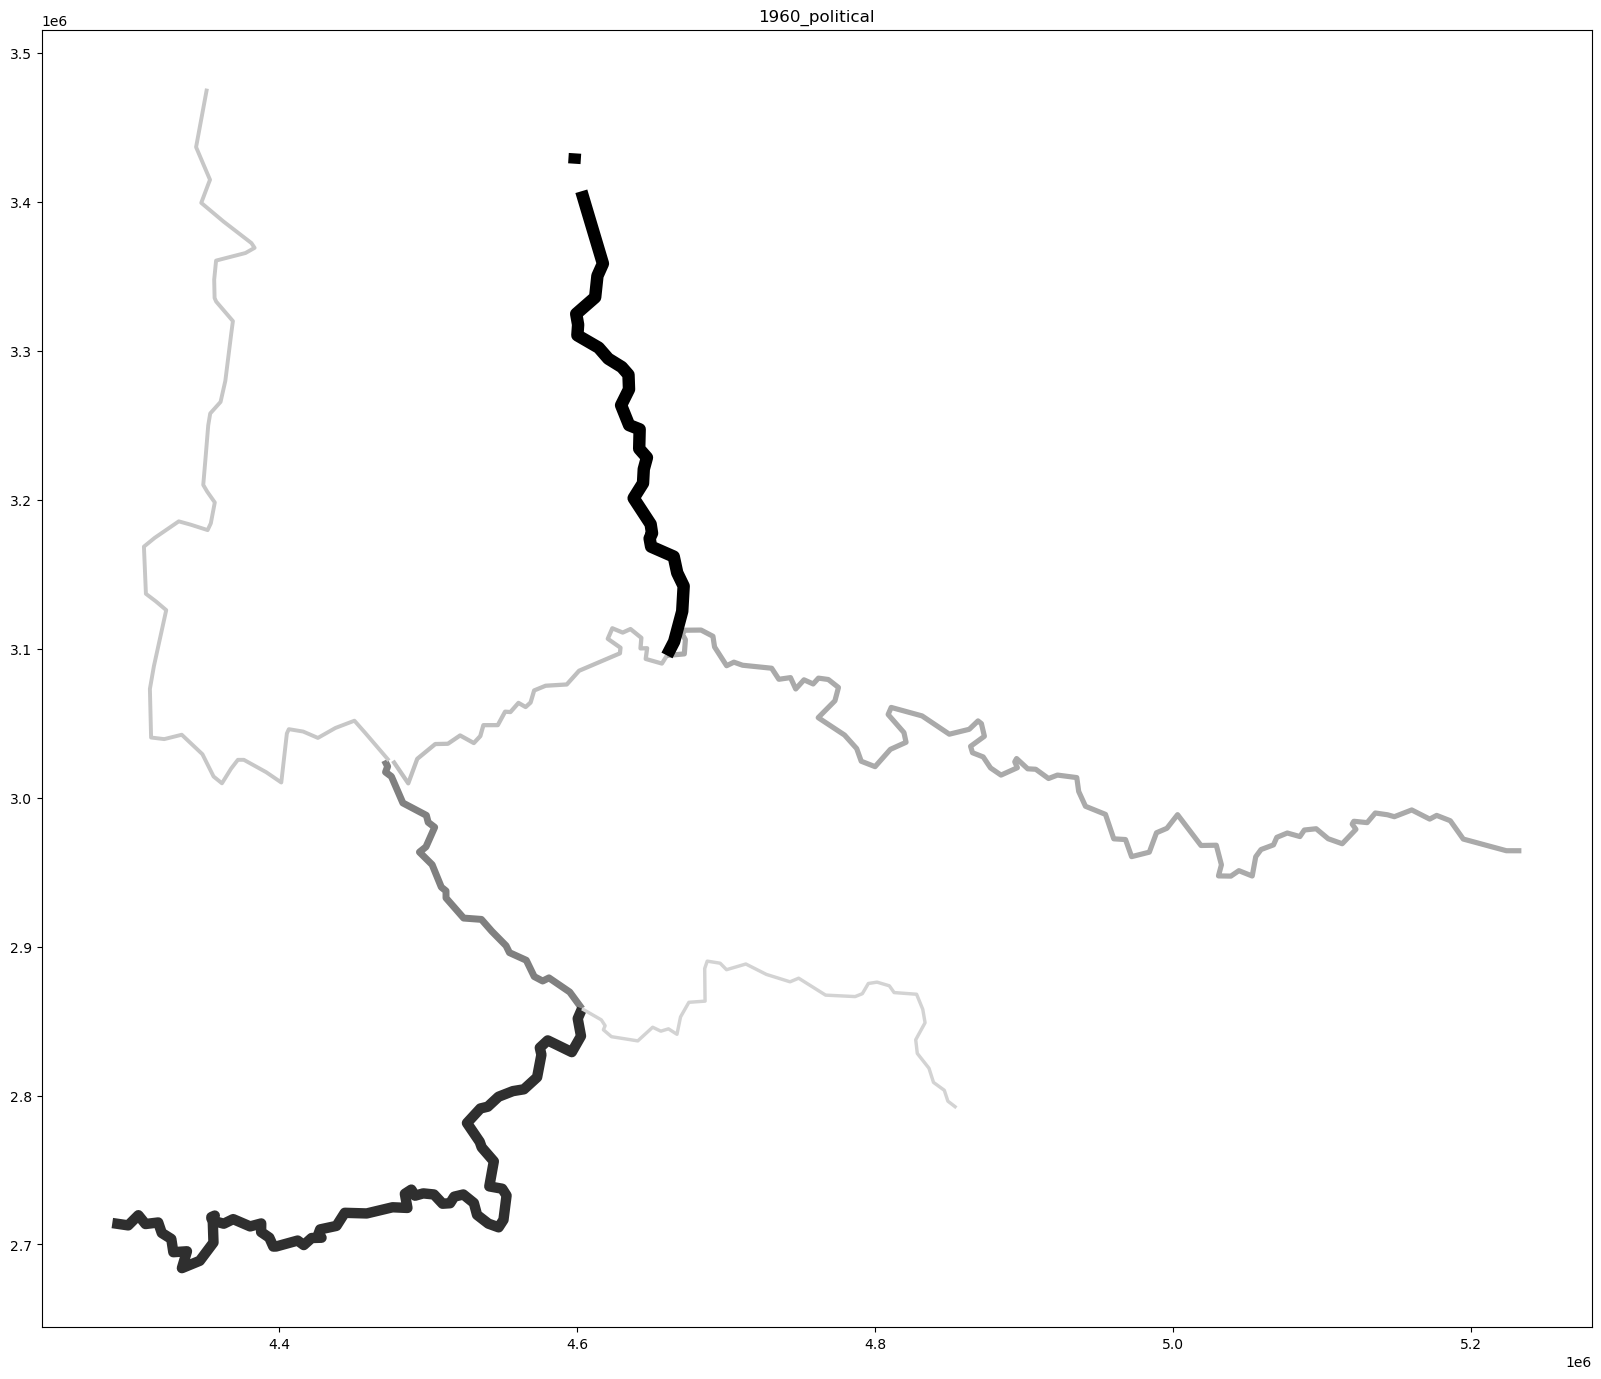

In [73]:
fig, ax = plt.subplots(figsize=(20,20))
generate_boundary_diagram("1960_political", ax=ax)

In [17]:
def generate_boundary_diagrams(boundary_lst):
    
    fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20,10), sharex=True, sharey=True)
    axs = axs.flatten()
    #aoi.plot(ax=ax[0], color='lightgray')
    #aoi.plot(ax=ax[1], color='lightgray')
    #cmap = plt.get_cmap("tab20")
    #colors = {bnd: cmap(i) for i,bnd in enumerate(boundary_lst)}
    
    for i, boundary in enumerate(boundary_list):
        aoi.plot(ax=axs[i], color='lightgray')
        generate_boundary_diagram(boundary, ax=axs[i])

    plt.tight_layout()
        #print(bnd)
        #boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
        #bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{bnd}_level_4.pq')

        #indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
        #left, right = np.unique(np.sort(indices, axis=0), axis=1)

        #mask = left == right
        #left = left[~mask]
        #right = right[~mask]
        #geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
        #left = boundary.NAME.iloc[left]
        #right = boundary.NAME.iloc[right]

        #border_widths = []

        #for l, r in zip(left, right):
        #    border_widths.append(bray_curtis_matrix.loc[l, r])
            
        #alphas = [(4*(np.exp(2*a) - 1)) for a in border_widths]
        #alphas = [(a - min(alphas)) / (max(alphas) - min(alphas)) for a in alphas]
        #border_widths = [(0.1 + 4*(np.exp(2*w) - 1)) for w in border_widths]

        #from matplotlib.patches import Patch
        #patches_legend = [Patch(facecolor=colors[bnd], label=bnd) for bnd in boundary_lst]

        #for geom, width, alpha in zip (geoms, border_widths, alphas):
        #    gpd.GeoSeries([geom]).plot(ax=ax[0], linewidth=width, color=colors[bnd], alpha=alpha)
        #    ax[0].legend(handles=patches_legend)


        #    gpd.GeoSeries([geom]).plot(ax=ax[1], linewidth=width, color="black", alpha=alpha)
            #ax.legend(handles=patches_legend)
    for ax in axs:
        ax.set_axis_off()

/tmp/ipykernel_287942/112614807.py:25: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(width)))


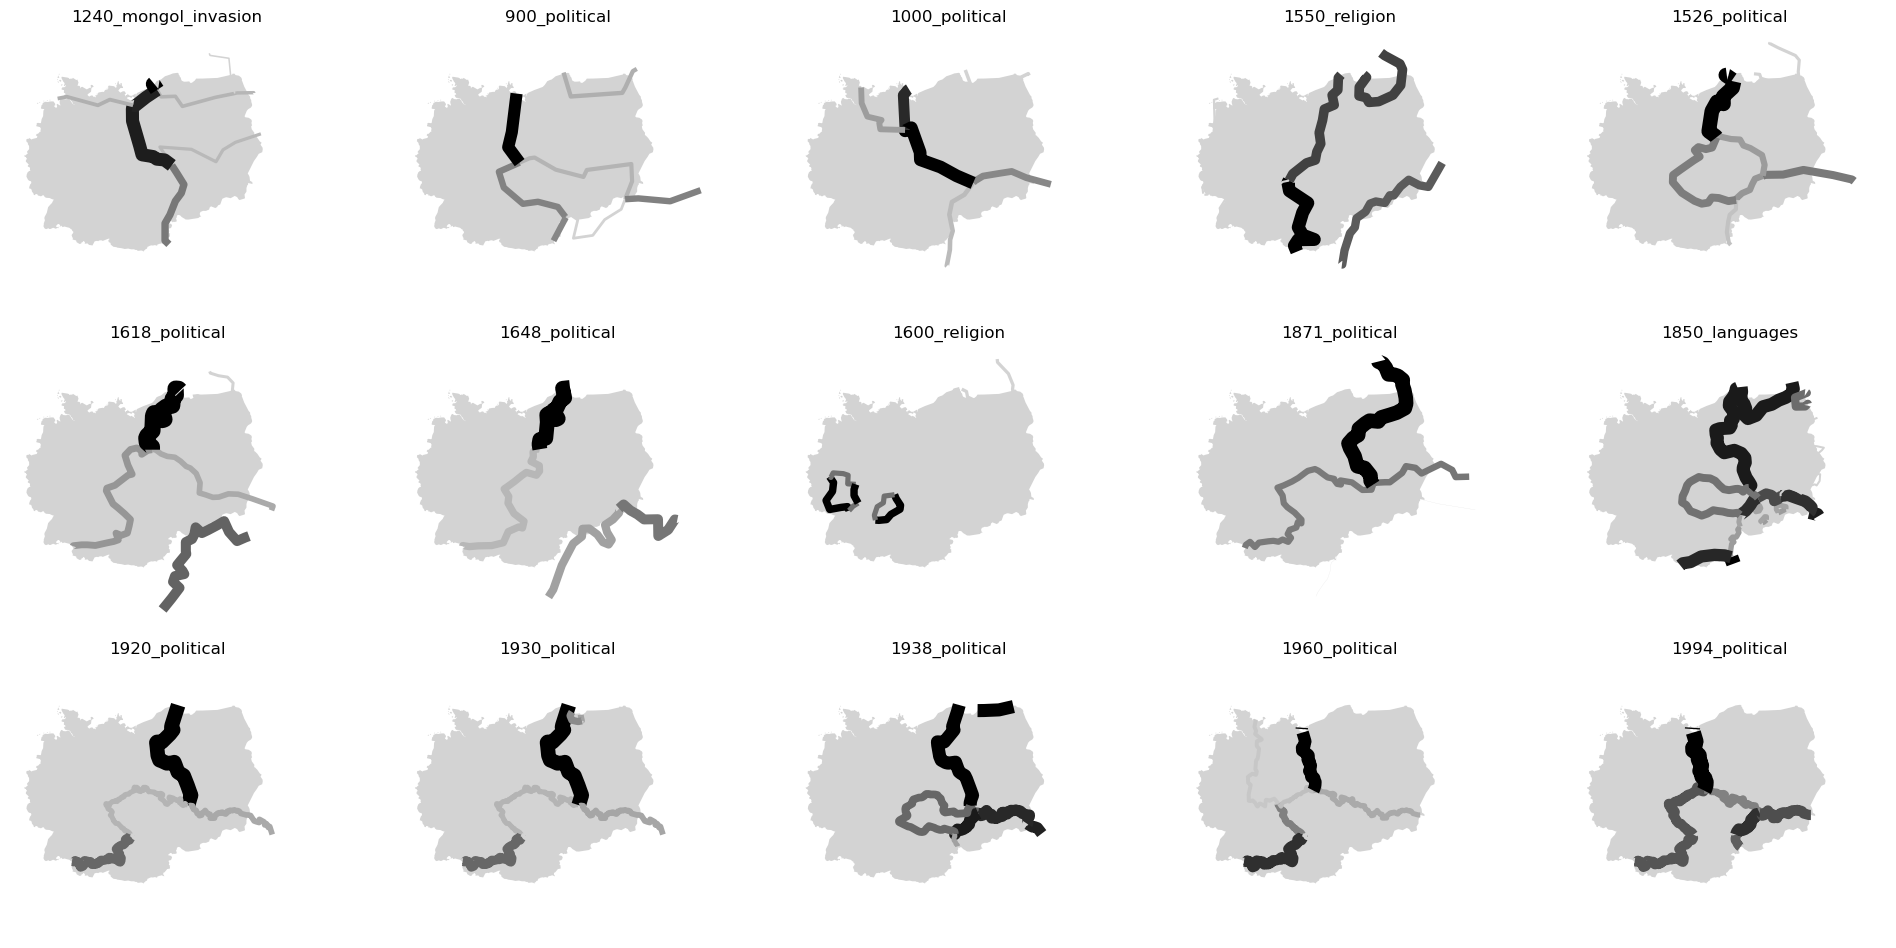

In [75]:

generate_boundary_diagrams(boundary_list)

## Gridding and clustering

In [19]:
import libpysal
import spopt
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate
import h3

In [20]:
hexed = h3fy(aoi, resolution=3)

/home/dancejod/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'Hexxd')

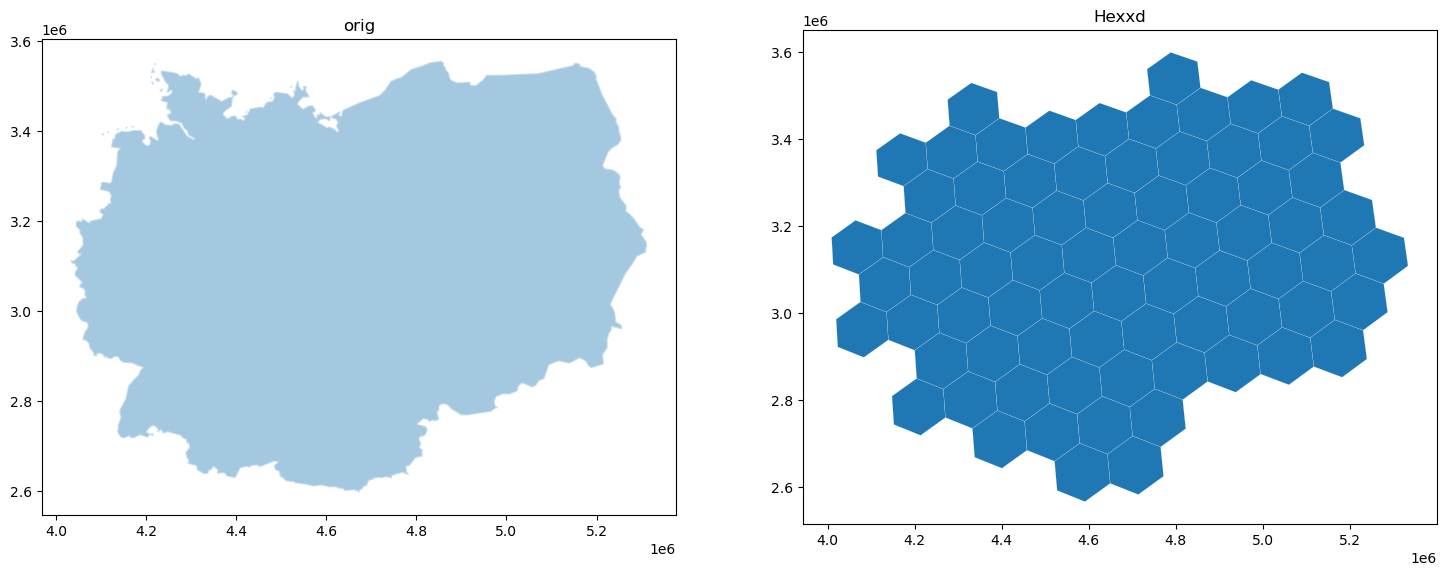

In [21]:
fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

aoi.plot(ax=axs[0], alpha=0.4, linewidth=1.6, edgecolor='white')
hexed.plot(ax=axs[1], alpha=1, linewidth=0.1, edgecolor='white')

axs[0].set_title('orig')
axs[1].set_title('Hexxd')


In [22]:
hexed

,geometry
hex_id,
831f52fffffffff,"POLYGON ((4948900.827 3247639.141, 5012283.856..."
831fabfffffffff,"POLYGON ((4322580.144 2865573.857, 4384564.554..."
831f88fffffffff,"POLYGON ((4400275.867 2642932.21, 4457929.792 ..."
831e2afffffffff,"POLYGON ((5108691.228 2942641.52, 5165268.677 ..."
831f55fffffffff,"POLYGON ((5152245.191 3530387.501, 5089637.06 ..."
...,...
831f8cfffffffff,"POLYGON ((4270425.806 2759403.495, 4332499.017..."
831f13fffffffff,"POLYGON ((4238285.619 3207119.268, 4242747.672..."
831e31fffffffff,"POLYGON ((4801848.552 2932456.398, 4794938.941..."


In [23]:
hexed.index.name = "NAME"

In [24]:
hex_w_buildings = get_building_counts_per_region(buildings, hexed, level="level_4")

In [25]:
joined = gpd.sjoin(buildings, hexed, how="left", predicate="within")
data = joined.groupby("NAME")["level_4"].value_counts().unstack().fillna(0)

In [26]:
data_norm = normalize_building_counts(data)

In [27]:
from sklearn import cluster

In [28]:
queen = graph.Graph.build_contiguity(hexed)

In [39]:
agg = cluster.AgglomerativeClustering(n_clusters=6, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete')

In [40]:
%%time
agg.fit(data_norm)

CPU times: user 3.49 ms, sys: 47 μs, total: 3.54 ms
Wall time: 3.47 ms


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse array of dtype 'float64'
	with 376 stored elements and shape (75, 75)>,
                        linkage='complete',
                        metric=<function braycurtis at 0x7d91b4d260c0>,
                        n_clusters=6)

In [41]:
hexed[['geometry']].explore(agg.labels_, categorical=True, tiles="CartoDB Positron")


In [32]:
from clustergram import Clustergram

In [33]:
clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
labels_dict = {}

for i, k in enumerate(clusters,start=1):
    labels_dict[i] = cluster.AgglomerativeClustering(n_clusters=k, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete').fit_predict(data_norm)
    
labels = pd.DataFrame(labels_dict)
labels

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,1,1,1,1,0,6,6,6,6,6,2,2,2,2,2
1,0,0,0,0,0,1,0,0,3,3,3,3,3,3,1,0
2,0,0,2,2,2,2,2,2,2,2,2,0,12,12,12,12
3,0,0,0,0,4,4,1,1,1,0,4,4,4,1,0,3
4,0,1,1,1,1,0,6,6,6,6,6,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0,0,2,2,2,2,2,2,2,2,2,0,1,0,3,1
71,0,0,0,0,0,1,0,0,3,3,3,3,3,3,1,0
72,0,0,2,2,2,2,2,2,2,2,2,0,1,0,6,6
73,0,0,0,3,3,3,3,3,8,8,8,8,8,8,8,8


In [96]:
data_norm.shape

(75, 16)

<Axes: xlabel='Number of clusters (k)', ylabel='Mean of the clusters'>

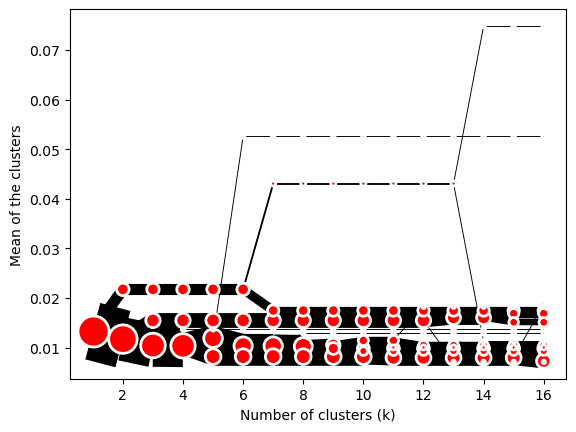

In [42]:
cgram = Clustergram.from_data(data_norm, labels)
cgram.plot(pca_weighted=False)

In [43]:
from bokeh.io import output_notebook
from bokeh.plotting import show
output_notebook()

Loading BokehJS ...

In [44]:
fig = cgram.bokeh(pca_weighted=False)
show(fig)

## Bray-Curtis

In [ ]:
cnt_table = get_building_counts_per_region(buildings, gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1960_political"))
cnt_table_norm = normalize_building_counts(cnt_table)
bray_curtis_matrix =compute_bc_matrix(cnt_table_norm)

<Axes: xlabel='NAME', ylabel='NAME'>

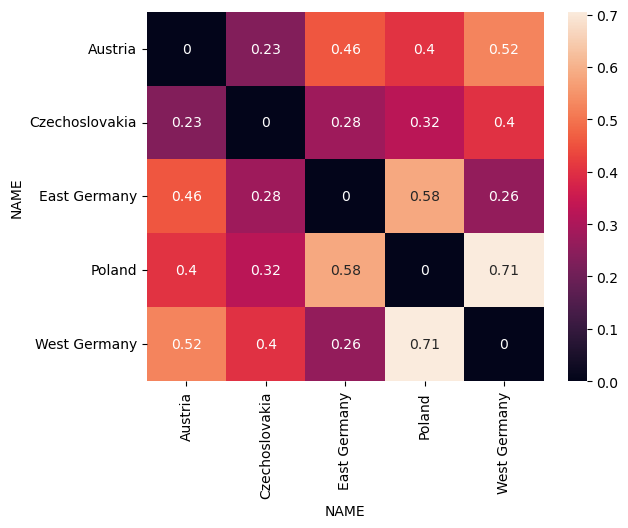

In [45]:
sns.heatmap(bray_curtis_matrix, annot=True)

In [ ]:
generate_bc_matrices(boundary_list, level_columns)

## Draw borders

In [ ]:
for bnd in boundary_list:
    boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
    joined = gpd.sjoin(buildings, boundary, how="left", predicate="within")
    generate_bc_heatmaps_for_boundary(level_columns, bnd)

In [ ]:
indices = boundaries.sindex.query(boundaries.geometry, predicate="intersects")
left, right = np.unique(np.sort(indices, axis=0), axis=1)

mask = left == right
left = left[~mask]
right = right[~mask]
geoms = boundaries.iloc[left].intersection(boundaries.iloc[right], align=False)
left = boundaries.NAME.iloc[left]
right = boundaries.NAME.iloc[right]

geoms.plot(cmap='tab20')

In [ ]:
geoms

In [ ]:
bray_curtis_matrix.loc[left.iloc[0],right.iloc[0]]

In [ ]:
geoms = gpd.GeoDataFrame(geometry=geoms)

In [ ]:
border_widths = []

for l, r in zip(left, right):
    border_widths.append(bray_curtis_matrix.loc[l, r])


In [ ]:
geoms["width"] = [np.sqrt(w) for w in border_widths]
geoms

In [ ]:
widths = (geoms.width - geoms.width.min()) / (geoms.width.max() - geoms.width.min())

geoms["map_width"] = widths
geoms

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
aoi.plot(ax=ax, color='lightgray')

geoms.plot(ax=ax, linewidth=geoms["map_width"], color='red')

## Principal Coordinates visualization

In [ ]:
from skbio.stats.ordination import pcoa
from skbio.stats.distance import DistanceMatrix

In [ ]:
pcoa_res = pcoa(DistanceMatrix(bray_curtis_matrix, ids=cnt_table_norm.columns))

In [ ]:
pcoa_res_df = pd.DataFrame(pcoa_res.samples.iloc[:, :2], index=cnt_table_norm.columns)

In [ ]:
pcoa_res_df

In [ ]:
sns.scatterplot(x="PC1", y="PC2", hue=pcoa_res_df.index, data=pcoa_res_df, s=100)